In [1]:
import pandas as pd
import numpy as np
import re
from pandas import json_normalize
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, auc, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
flag = pd.read_csv("./data/train/train_flag.csv")
flag.NAME_CONTRACT_TYPE = flag.NAME_CONTRACT_TYPE.str.strip()
flag.NAME_CONTRACT_TYPE = flag.NAME_CONTRACT_TYPE.str.lower()
flag = flag.sort_values(["uid"])
flag.head(2)

,uid,NAME_CONTRACT_TYPE,TARGET
160539,AAA08065248,revolving loans,0
70453,AAA09044550,cash loans,0


In [3]:
with open("./data/train/accounts_data_train.json", "r") as file:
    data = json.load(file)

flattened_data = [item for sublist in data for item in sublist]
account = json_normalize(flattened_data)

account["open_date"] = pd.to_datetime(account["open_date"])
account["closed_date"] = pd.to_datetime(account["closed_date"])
account.credit_type = account.credit_type.str.strip()
account.credit_type = account.credit_type.str.lower()
account.head(2)

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,consumer credit,272745.0,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550
1,consumer credit,4500.0,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550


In [4]:
# Calculate Number Missed Due Dates

def count_missed_due_dates(payment_hist_string):
    count=0
    if pd.isna(payment_hist_string):
        return 0
    for i in range(0,len(payment_hist_string),3):
        if payment_hist_string[i:i+3]!="000":
            count+=1
    return count

account['missed_due_dates'] = account['payment_hist_string'].apply(count_missed_due_dates)
account.head(2)

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,missed_due_dates
0,consumer credit,272745.0,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550,1
1,consumer credit,4500.0,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550,2


In [5]:
# Calculating Loan Duration

account["loan_duration"] = (account["closed_date"]-account["open_date"]).dt.days
account.head(2)

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,missed_due_dates,loan_duration
0,consumer credit,272745.0,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550,1,518.0
1,consumer credit,4500.0,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550,2,504.0


In [6]:
with open("./data/train/enquiry_data_train.json", "r") as file:
    data = json.load(file)

flattened_data = [item for sublist in data for item in sublist]
enquiry = json_normalize(flattened_data)

enquiry["enquiry_date"] = pd.to_datetime(enquiry["enquiry_date"])
enquiry.enquiry_type = enquiry.enquiry_type.str.strip()
enquiry.enquiry_type = enquiry.enquiry_type.str.lower()
enquiry.head(2)

,enquiry_type,enquiry_amt,enquiry_date,uid
0,interbank credit,168839,2020-11-08,AAA08065248
1,mobile operator loan,268392,2020-09-20,AAA08065248


In [7]:
# Appending account data to enquiry data, left join is used as no. of unique uid for enquiry data and flag is same

data_sum = pd.merge(enquiry, account,left_on=["uid","enquiry_type"],right_on=["uid","credit_type"],how="left")
data_sum = data_sum[['uid','enquiry_amt','loan_amount','amount_overdue','missed_due_dates','loan_duration']]
data_sum = data_sum.groupby('uid').mean().reset_index()
data_sum = pd.merge(data_sum,flag[["uid","TARGET"]],on="uid")
data_sum.head(2)

,uid,enquiry_amt,loan_amount,amount_overdue,missed_due_dates,loan_duration,TARGET
0,AAA08065248,187696.181818,NaN,NaN,NaN,NaN,0
1,AAA09044550,102592.592593,138622.5,0.0,1.5,511.0,0


In [8]:
# Find Null count

data_sum.isna().sum()

uid                      0
enquiry_amt              0
loan_amount         171692
amount_overdue      171691
missed_due_dates    171691
loan_duration       195368
TARGET                   0
dtype: int64

In [9]:
# Replace Null by 0 
data_sum = data_sum.fillna(0)
data_sum

,uid,enquiry_amt,loan_amount,amount_overdue,missed_due_dates,loan_duration,TARGET
0,AAA08065248,187696.181818,0.000,0.0,0.000000,0.000000,0
1,AAA09044550,102592.592593,138622.500,0.0,1.500000,511.000000,0
2,AAA10545297,94071.428571,80996.445,0.0,0.000000,0.000000,0
3,AAA14112888,97666.666667,43771.500,0.0,0.000000,92.000000,0
4,AAA20326915,66000.000000,0.000,0.0,0.000000,0.000000,0
...,...,...,...,...,...,...,...
261378,ZZZ74526004,111400.000000,37864.500,0.0,0.666667,289.333333,0
261379,ZZZ78449185,359326.833333,0.000,0.0,0.000000,0.000000,0
261380,ZZZ79008454,28000.000000,0.000,0.0,0.000000,0.000000,0
261381,ZZZ81253108,103551.724138,2529720.000,0.0,0.000000,547.000000,0


In [10]:
# Check if there is collinearity between columns

data_sum.corr()

,enquiry_amt,loan_amount,amount_overdue,missed_due_dates,loan_duration,TARGET
enquiry_amt,1.000000,0.006773,-0.001516,0.001754,-0.007123,-0.020950
loan_amount,0.006773,1.000000,0.005308,0.074603,0.200549,-0.014842
amount_overdue,-0.001516,0.005308,1.000000,0.059077,0.006616,0.007467
missed_due_dates,0.001754,0.074603,0.059077,1.000000,0.165994,-0.002612
loan_duration,-0.007123,0.200549,0.006616,0.165994,1.000000,-0.022884
TARGET,-0.020950,-0.014842,0.007467,-0.002612,-0.022884,1.000000


# EDA

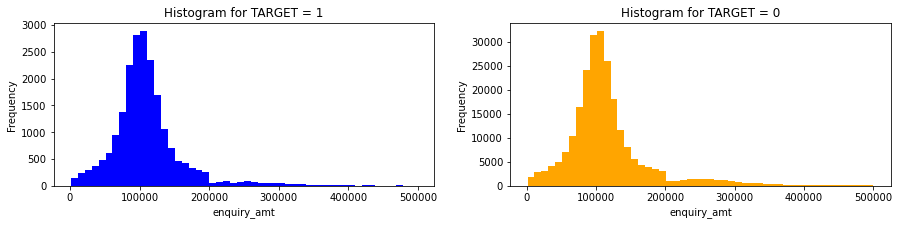

In [11]:
plt.figure(figsize=(15,3))

plt.subplot(1, 2, 1)
plt.hist(data_sum[data_sum["TARGET"] == 1]["enquiry_amt"], bins=50, color='blue')
plt.title("Histogram for TARGET = 1")
plt.xlabel("enquiry_amt")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(data_sum[data_sum["TARGET"] == 0]["enquiry_amt"], bins=50, color='orange')
plt.title("Histogram for TARGET = 0")
plt.xlabel("enquiry_amt")
plt.ylabel("Frequency")

plt.show()

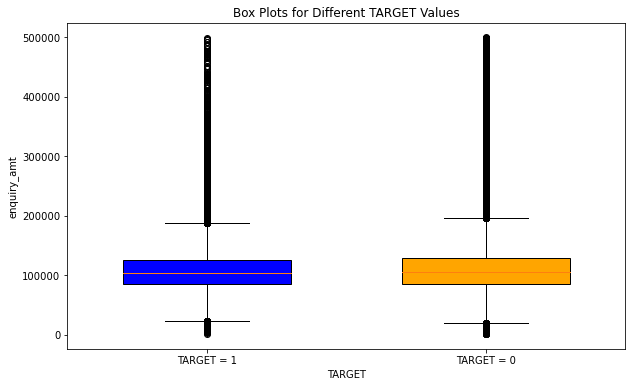

In [12]:
plt.figure(figsize=(10, 6))

plt.boxplot(data_sum[data_sum["TARGET"] == 1]["enquiry_amt"], positions=[1], widths=0.6, patch_artist=True, boxprops=dict(facecolor='blue'))
plt.boxplot(data_sum[data_sum["TARGET"] == 0]["enquiry_amt"], positions=[2], widths=0.6, patch_artist=True, boxprops=dict(facecolor='orange'))

plt.title("Box Plots for Different TARGET Values")
plt.xlabel("TARGET")
plt.ylabel("enquiry_amt")
plt.xticks([1, 2], ["TARGET = 1", "TARGET = 0"])
plt.show()

In [13]:
data_sum.head(2)

,uid,enquiry_amt,loan_amount,amount_overdue,missed_due_dates,loan_duration,TARGET
0,AAA08065248,187696.181818,0.0,0.0,0.0,0.0,0
1,AAA09044550,102592.592593,138622.5,0.0,1.5,511.0,0


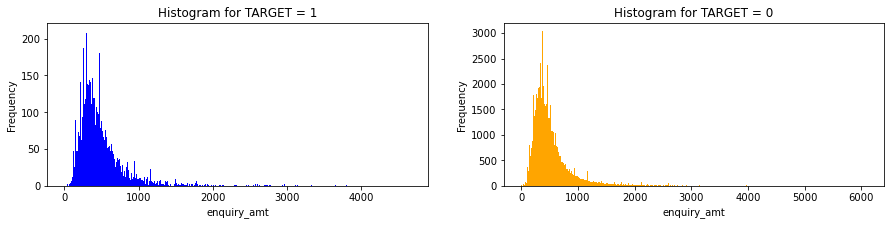

In [14]:
plt.figure(figsize=(15,3))

plt.subplot(1, 2, 1)
plt.hist(np.sqrt(data_sum[(data_sum["TARGET"] == 1) & (data_sum["loan_amount"] > 0)]["loan_amount"]), bins=500, color='blue')
plt.title("Histogram for TARGET = 1")
plt.xlabel("enquiry_amt")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(np.sqrt(data_sum[(data_sum["TARGET"] == 0) & (data_sum["loan_amount"] > 0)]["loan_amount"]), bins=500, color='orange')
plt.title("Histogram for TARGET = 0")
plt.xlabel("enquiry_amt")
plt.ylabel("Frequency")

plt.show()

In [15]:
data_sum[data_sum["loan_amount"] == 0].shape

(173359, 7)

In [16]:
data_sum.shape

(261383, 7)

In [17]:
# There are to many raws where data_sum["loan_amount"]==0

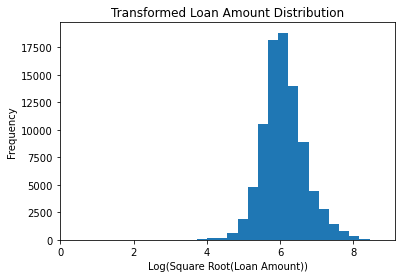

In [18]:
transformed_values = np.sqrt(data_sum[(data_sum["loan_amount"] > 0)]["loan_amount"])
plt.hist(np.log(transformed_values), bins=30)
plt.title("Transformed Loan Amount Distribution")
plt.xlabel("Log(Square Root(Loan Amount))")
plt.ylabel("Frequency")
plt.show()

# There there were not such high rows with  loan_amount=0, the loan_amount distibution could have be transformed into normal distribution

(260567, 7)


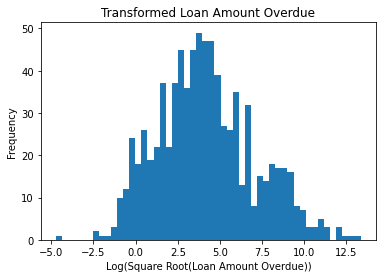

In [19]:
# Similar comments can be made for amount_overdue as well
print(data_sum[data_sum["amount_overdue"]==0].shape)
p = data_sum[(data_sum["amount_overdue"] > 0)]["amount_overdue"]
plt.hist(np.log(p),bins=50)
plt.title("Transformed Loan Amount Overdue")
plt.xlabel("Log(Square Root(Loan Amount Overdue))")
plt.ylabel("Frequency")
plt.show()

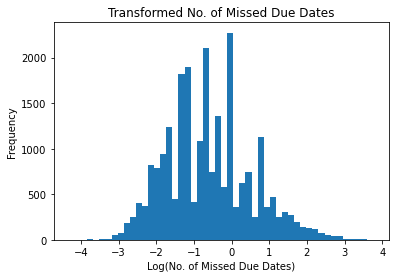

In [20]:
p = data_sum[(data_sum["missed_due_dates"] > 0)]["missed_due_dates"]
plt.hist(np.log(p),bins=50)
plt.title("Transformed No. of Missed Due Dates")
plt.xlabel("Log(No. of Missed Due Dates)")
plt.ylabel("Frequency")
plt.show()

In [21]:
data_sum[(data_sum["loan_duration"] == 0)].shape

(195433, 7)

# Model Training

In [32]:
# To find of which algorithm is best suited for the data

models = {
    "logistic_regression": {
        "model": LogisticRegression(solver="liblinear", multi_class="auto"),
        "params": {
            "logisticregression__C": [10, 25, 1000]
        }
    },
    "random_forest": {
        "model": RandomForestClassifier(),
        "params": {
            "randomforestclassifier__n_estimators": [10, 25, 100]
        }
    },
    "xgboost": {
        "model": xgb.XGBClassifier(),
        "params": {
            "xgbclassifier__learning_rate": [0.01, 0.1, 0.2],
            "xgbclassifier__n_estimators": [50, 100, 200]
        }
    }
}

In [23]:
X = data_sum.drop(columns=["TARGET","uid"])
y = data_sum["TARGET"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
scores = []
best_estimators = {}

for algo, mp in models.items():
    pipe = make_pipeline(StandardScaler(), mp["model"])
    clf = GridSearchCV(pipe, mp["params"], cv=5, scoring="roc_auc")
    clf.fit(X_train_scaled, y_train)
    scores.append({
        "model": algo,
        "best_score": clf.best_score_,
        "best_params": clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

performance = pd.DataFrame(scores, columns=["model", "best_score", "best_params"])
performance

,model,best_score,best_params
0,logistic_regression,0.529267,{'logisticregression__C': 25}
1,random_forest,0.514084,{'randomforestclassifier__n_estimators': 100}
2,xgboost,0.539334,"{'xgbclassifier__learning_rate': 0.01, 'xgbcla..."


# DATA BALANCING

In [25]:
data_sum["TARGET"].value_counts()

# The dataset is unbalanced, so for better predication we somehow need to balance the data
# Few ways to balance the data are 
#   a - Under Sampling
#   b - Over Sampling
#   c - Weighted Ratio
#   d - Smoth

0    240326
1     21057
Name: TARGET, dtype: int64

### UNDERSAMPLING

In [26]:
data_0 = data_sum[data_sum["TARGET"]==0].sample(21000)
data_1 = data_sum[data_sum["TARGET"]==1]
con_data = pd.concat([data_0,data_1],axis=0)

In [27]:
X = con_data.drop(columns=["TARGET","uid"])
y = con_data["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
scores = []
best_estimators = {}

for algo, mp in models.items():
    pipe = make_pipeline(StandardScaler(), mp["model"])
    clf = GridSearchCV(pipe, mp["params"], cv=5, scoring="roc_auc")
    clf.fit(X_train_scaled, y_train)
    scores.append({
        "model": algo,
        "best_score": clf.best_score_,
        "best_params": clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

performance_undersampling = pd.DataFrame(scores, columns=["model", "best_score", "best_params"])
performance_undersampling

,model,best_score,best_params
0,logistic_regression,0.535059,{'logisticregression__C': 1000}
1,random_forest,0.515102,{'randomforestclassifier__n_estimators': 100}
2,xgboost,0.540796,"{'xgbclassifier__learning_rate': 0.01, 'xgbcla..."


### Over Sampling

In [29]:
data_0 = data_sum[data_sum["TARGET"]==0]
data_1 = data_sum[data_sum["TARGET"]==1].sample(240000,replace=True)
con_data = pd.concat([data_0,data_1],axis=0)

In [30]:
X = con_data.drop(columns=["TARGET","uid"])
y = con_data["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
scores = []
best_estimators = {}

for algo, mp in models.items():
    pipe = make_pipeline(StandardScaler(), mp["model"])
    clf = GridSearchCV(pipe, mp["params"], cv=5, scoring="roc_auc")
    clf.fit(X_train_scaled, y_train)
    scores.append({
        "model": algo,
        "best_score": clf.best_score_,
        "best_params": clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

performance_oversampling = pd.DataFrame(scores, columns=["model", "best_score", "best_params"])
performance_oversampling

,model,best_score,best_params
0,logistic_regression,0.531740,{'logisticregression__C': 1000}
1,random_forest,0.856504,{'randomforestclassifier__n_estimators': 100}
2,xgboost,0.645700,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas..."


In [32]:
X = con_data.drop(columns=["TARGET","uid"])
y = con_data["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
scores = []
best_estimators = {}

for algo, mp in models.items():
    pipe = make_pipeline(StandardScaler(), mp["model"])
    clf = GridSearchCV(pipe, mp["params"], cv=5, scoring="roc_auc")
    clf.fit(X_train_scaled, y_train)
    scores.append({
        "model": algo,
        "best_score": clf.best_score_,
        "best_params": clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

performance_oversampling = pd.DataFrame(scores, columns=["model", "best_score", "best_params"])
performance_oversampling

,model,best_score,best_params
0,logistic_regression,0.532151,{'logisticregression__C': 1000}
1,random_forest,0.856654,{'randomforestclassifier__n_estimators': 100}
2,xgboost,0.648607,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas..."


### Weighted Ratio

In [34]:
X = data_sum.drop(columns=["TARGET","uid"])
y = data_sum["TARGET"]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
models = {
    "logistic_regression": {
        "model": LogisticRegression(solver="liblinear", multi_class="auto"),
        "params": {
            "logisticregression__C": [10, 25, 1000],
            "logisticregression__class_weight": [{0: 1, 1: 10}]  # Set class weights here
        }
    },
    "random_forest": {
        "model": RandomForestClassifier(),
        "params": {
            "randomforestclassifier__n_estimators": [10, 25, 100],
            "randomforestclassifier__class_weight": [{0: 1, 1: 10}]  # Set class weights here
        }
    },
    "xgboost": {
        "model": xgb.XGBClassifier(),
        "params": {
            "xgbclassifier__learning_rate": [0.01, 0.1, 0.2],
            "xgbclassifier__n_estimators": [50, 100, 200],
            "xgbclassifier__scale_pos_weight": [10]  # Set class weights here
        }
    },
}

scores = []
best_estimators = {}

for algo, mp in models.items():
    pipe = make_pipeline(StandardScaler(), mp["model"])
    clf = GridSearchCV(pipe, mp["params"], cv=5, scoring="roc_auc")
    clf.fit(X_train_scaled, y_train)
    scores.append({
        "model": algo,
        "best_score": clf.best_score_,
        "best_params": clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

performance_weighted = pd.DataFrame(scores, columns=["model", "best_score", "best_params"])
performance_weighted

,model,best_score,best_params
0,logistic_regression,0.529758,"{'logisticregression__C': 1000, 'logisticregre..."
1,random_forest,0.516275,{'randomforestclassifier__class_weight': {0: 1...
2,xgboost,0.538256,"{'xgbclassifier__learning_rate': 0.01, 'xgbcla..."


### SMOTE

In [37]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

X = data_sum.drop(columns=["TARGET","uid"])
y = data_sum["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Random Forest
print("###################### Random Forest ######################")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the performance
#print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC_AUC:",roc_auc_score(y_pred,y_test))


# XGBOOST
print("###################### XGBOOST ######################")
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)
xgb_predictions = xgb_model.predict(X_test_scaled)

#print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC_AUC:",roc_auc_score(y_pred,y_test))

# Logistics Regression
print("###################### Logistic Regression ######################")
logreg_model = LogisticRegression()
logreg_model.fit(X_train_resampled, y_train_resampled)
logreg_predictions = logreg_model.predict(X_test_scaled)


#print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC_AUC:",roc_auc_score(y_pred,y_test))

###################### Random Forest ######################
Accuracy: 0.6534422403733956
ROC_AUC: 0.5030828148936294
###################### XGBOOST ######################
Accuracy: 0.6534422403733956
ROC_AUC: 0.5030828148936294
###################### Logistic Regression ######################
Accuracy: 0.6534422403733956
ROC_AUC: 0.5030828148936294


# Comparing Performances

##### Although performance_oversample appears to be the best, due to over-sampling, there are considerable chances of data leakage, i.e. the data is testing data explosed to model while training. However, for the purpose of simplicity, we have chosen over-sampling model.

# OUTPUT

In [139]:
flag = pd.read_csv("./data/test/test_flag.csv")
flag.NAME_CONTRACT_TYPE = flag.NAME_CONTRACT_TYPE.str.strip()
flag.NAME_CONTRACT_TYPE = flag.NAME_CONTRACT_TYPE.str.lower()
flag = flag.sort_values(["uid"])
flag.head(2)

,uid,NAME_CONTRACT_TYPE
37456,AAA02107680,cash loans
16234,AAA14437029,cash loans


In [140]:
with open("./data/test/accounts_data_test.json", "r") as file:
    data = json.load(file)

flattened_data = [item for sublist in data for item in sublist]
test_account = json_normalize(flattened_data)

test_account["open_date"] = pd.to_datetime(test_account["open_date"])
test_account["closed_date"] = pd.to_datetime(test_account["closed_date"])
test_account.loc[test_account["closed_date"].isna(),"closed_date"] = "2023-11-29"
test_account.credit_type = test_account.credit_type.str.strip()
test_account.credit_type = test_account.credit_type.str.lower()

test_account['missed_due_dates'] = test_account['payment_hist_string'].apply(count_missed_due_dates)
test_account["loan_duration"] = (test_account["closed_date"]-test_account["open_date"]).dt.days

test_account['missed_due_dates'] = test_account['payment_hist_string'].apply(count_missed_due_dates)
test_account.loc[test_account["closed_date"].isna(),"closed_date"] = "2023-11-29"
test_account["loan_duration"] = (test_account["closed_date"]-test_account["open_date"]).dt.days
test_account.head(2)

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,missed_due_dates,loan_duration
0,consumer credit,31630.50,0.0,2014-03-30,2014-11-29,000000000000000000000000,AAA14437029,0,244
1,consumer credit,14613.39,0.0,2014-06-01,2014-11-03,000000000000000,AAA14437029,0,155


In [141]:
with open("./data/test/enquiry_data_test.json", "r") as file:
    data = json.load(file)

flattened_data = [item for sublist in data for item in sublist]
test_enquiry = json_normalize(flattened_data)


test_enquiry["enquiry_date"] = pd.to_datetime(test_enquiry["enquiry_date"])
test_enquiry.enquiry_type = test_enquiry.enquiry_type.str.strip()
test_enquiry.enquiry_type = test_enquiry.enquiry_type.str.lower()
test_enquiry.head(2)

,enquiry_type,enquiry_amt,enquiry_date,uid
0,car loan,143000,2020-12-13,AAA02107680
1,real estate loan,174000,2020-12-01,AAA14437029


In [142]:
test_data = pd.merge(test_enquiry,test_account,left_on=["uid","enquiry_type"],right_on=["uid","credit_type"],how="left")
test_data = test_data.groupby("uid").mean().reset_index()
test_data.head(2)

,uid,enquiry_amt,loan_amount,amount_overdue,missed_due_dates,loan_duration
0,AAA02107680,143000.0,NaN,NaN,NaN,NaN
1,AAA14437029,92250.0,NaN,NaN,NaN,NaN


In [143]:
test_data = test_data.fillna(0)
test_data.head(2)

,uid,enquiry_amt,loan_amount,amount_overdue,missed_due_dates,loan_duration
0,AAA02107680,143000.0,0.0,0.0,0.0,0.0
1,AAA14437029,92250.0,0.0,0.0,0.0,0.0


In [144]:
# Standardize the features
output = scaler.transform(test_data.drop(columns="uid"))

# Prediction

In [145]:
# Run The Below code Before Running the final Cell (To make sure value of best_estimators not over-writed )


data_sum = data_sum[~data_sum.loan_duration.isna()]
data_0 = data_sum[data_sum["TARGET"]==0]
data_1 = data_sum[data_sum["TARGET"]==1].sample(240000,replace=True)
con_data = pd.concat([data_0,data_1],axis=0)


X = con_data.drop(columns=["TARGET","uid"])
y = con_data["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
scores = []
best_estimators = {}

for algo, mp in models.items():
    pipe = make_pipeline(StandardScaler(), mp["model"])
    clf = GridSearchCV(pipe, mp["params"], cv=5, scoring="roc_auc")
    clf.fit(X_train_scaled, y_train)
    scores.append({
        "model": algo,
        "best_score": clf.best_score_,
        "best_params": clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

performance_oversampling = pd.DataFrame(scores, columns=["model", "best_score", "best_params"])
performance_oversampling

,model,best_score,best_params
0,logistic_regression,0.531697,{'logisticregression__C': 10}
1,random_forest,0.856509,{'randomforestclassifier__n_estimators': 100}
2,xgboost,0.644677,"{'xgbclassifier__learning_rate': 0.2, 'xgbclas..."


In [146]:
# Let's keep the threshold to be default threshold (i.e.) for simplicity

best = best_estimators["random_forest"]
clf_into_class = best.predict(output)
probabilities = best.predict_proba(output)

In [147]:
# ADD TARGET column to test_data dataframe
test_data["TARGET"] = clf_into_class
test_data.head(2)

,uid,enquiry_amt,loan_amount,amount_overdue,missed_due_dates,loan_duration,TARGET
0,AAA02107680,143000.0,0.0,0.0,0.0,0.0,0
1,AAA14437029,92250.0,0.0,0.0,0.0,0.0,0


In [148]:
flag = pd.read_csv("./data/test/test_flag.csv")
flag.NAME_CONTRACT_TYPE = flag.NAME_CONTRACT_TYPE.str.strip()
flag.NAME_CONTRACT_TYPE = flag.NAME_CONTRACT_TYPE.str.lower()
flag = flag.sort_values(["uid"])
flag.head(2)

,uid,NAME_CONTRACT_TYPE
37456,AAA02107680,cash loans
16234,AAA14437029,cash loans


In [149]:
final_output = pd.merge(flag,test_data[["uid","TARGET"]],on="uid")
final_output.head(2)

,uid,NAME_CONTRACT_TYPE,TARGET
0,AAA02107680,cash loans,0
1,AAA14437029,cash loans,0


In [160]:
final_output.to_csv("Kalpak_Choudhari.csv")

In [163]:
p = pd.read_csv("Kalpak_Choudhari.csv")
p["TARGET"].value_counts()

0    45657
1      470
Name: TARGET, dtype: int64